<a href="https://colab.research.google.com/github/khairulomar/Melbourne_pedestrian/blob/master/Melbourne_pedestrian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install sodapy

In [5]:
import pandas as pd
import numpy as np
import datetime as dt
from sodapy import Socrata
import progressbar
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing

# Investigate overall data

In [8]:
# Import data from API

client = Socrata('data.melbourne.vic.gov.au',
                 'rU9dviaJKpt9U9Mk9aPFFOIvS',
                 'khairul@yahoo.com',
                 'KhairulMaps2019&')

# To begin, download all data but limit to only for monday noons for overview
results = client.get("b2ak-trbp", day='Monday', time=12, limit=50000)

dfraw0 = pd.DataFrame.from_records(results)
display(len(dfraw0))
display(dfraw0.head())

17822

,id,date_time,year,month,mdate,day,time,sensor_id,sensor_name,hourly_counts
0,2891212,2019-11-04T12:00:00.000,2019,November,4,Monday,12,4,Town Hall (West),4535
1,2891213,2019-11-04T12:00:00.000,2019,November,4,Monday,12,17,Collins Place (South),1145
2,2891214,2019-11-04T12:00:00.000,2019,November,4,Monday,12,18,Collins Place (North),421
3,2891215,2019-11-04T12:00:00.000,2019,November,4,Monday,12,53,Collins St (North),2570
4,2891216,2019-11-04T12:00:00.000,2019,November,4,Monday,12,2,Bourke Street Mall (South),5227


In [9]:
dfraw0.columns

Index(['id', 'date_time', 'year', 'month', 'mdate', 'day', 'time', 'sensor_id',
       'sensor_name', 'hourly_counts'],
      dtype='object')

In [10]:
# First round of cleaning
df = dfraw0.copy()
df['date_time'] = pd.to_datetime(df['date_time'])
df['date'] = df['date_time'].dt.date
df['year'] = df['year'].astype('int')
df['hourly_counts'] = df['hourly_counts'].astype('int')
df['sensor'] = df['sensor_id'].map(lambda row: '0'+str(row) if int(row)<10 else row) + " : " + df['sensor_name']
df['sensor_id'] = df['sensor_id'].astype('int')
df.dtypes

id                       object
date_time        datetime64[ns]
year                      int64
month                    object
mdate                    object
day                      object
time                     object
sensor_id                 int64
sensor_name              object
hourly_counts             int64
date                     object
sensor                   object
dtype: object

In [11]:
# Convert to pivot for plotting
table = pd.pivot_table(df, values='hourly_counts', index='date',
                       columns='sensor', aggfunc=np.sum)
table.head(2)

sensor,01 : Bourke Street Mall (North),02 : Bourke Street Mall (South),03 : Melbourne Central,04 : Town Hall (West),05 : Princes Bridge,06 : Flinders Street Station Underpass,07 : Birrarung Marr,08 : Webb Bridge,09 : Southern Cross Station,10 : Victoria Point,11 : Waterfront City,12 : New Quay,13 : Flagstaff Station,14 : Sandridge Bridge,15 : State Library,16 : Australia on Collins,17 : Collins Place (South),18 : Collins Place (North),19 : Chinatown-Swanston St (North),20 : Chinatown-Lt Bourke St (South),21 : Bourke St-Russell St (West),22 : Flinders St-Elizabeth St (East),23 : Spencer St-Collins St (South),24 : Spencer St-Collins St (North),25 : Melbourne Convention Exhibition Centre,26 : QV Market-Elizabeth St (West),27 : QV Market-Peel St,28 : The Arts Centre,29 : St Kilda Rd-Alexandra Gardens,30 : Lonsdale St (South),31 : Lygon St (West),32 : City Square,33 : Flinders St-Spring St (West),34 : Flinders St-Spark La,35 : Southbank,36 : Queen St (West),37 : Lygon St (East),38 : Flinders St-Swanston St (West),39 : Alfred Place,40 : Lonsdale St-Spring St (West),41 : Flinders La-Swanston St (West),42 : Grattan St-Swanston St (West),43 : Monash Rd-Swanston St (West),44 : Tin Alley-Swanston St (West),45 : Little Collins St-Swanston St (East),46 : Pelham St (S),46 : Pelham St (South),47 : Melbourne Central-Elizabeth St (East),48 : QVM-Queen St (East),49 : QVM-Therry St (South),50 : Faraday St-Lygon St (West),51 : QVM-Franklin St (North),52 : Elizabeth St-Lonsdale St (South),53 : Collins St (North),54 : Lincoln-Swanston (West),54 : Lincoln-Swanston(West),55 : Elizabeth St-La Trobe St (East),56 : Lonsdale St - Elizabeth St (North),57 : Bourke St Bridge,58 : Bourke St - Spencer St (North),59 : Swanston St - RMIT Building 80,60 : Flinders La - Swanston St (West) Temp,60 : Flinders la - Swanston St (West) Temp,61 : Swanston St - RMIT Building 14,62 : La Trobe St (North),63 : 231 Bourke St,64 : Royal Pde-Grattan St
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-05-04,3532.0,2761.0,NaN,3789.0,1492.0,1931.0,NaN,NaN,808.0,529.0,93.0,267.0,1130.0,529.0,1829.0,2733.0,1442.0,722.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-05-11,3246.0,2483.0,NaN,3434.0,1269.0,1874.0,NaN,NaN,752.0,477.0,182.0,343.0,1097.0,602.0,1742.0,2552.0,1526.0,782.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


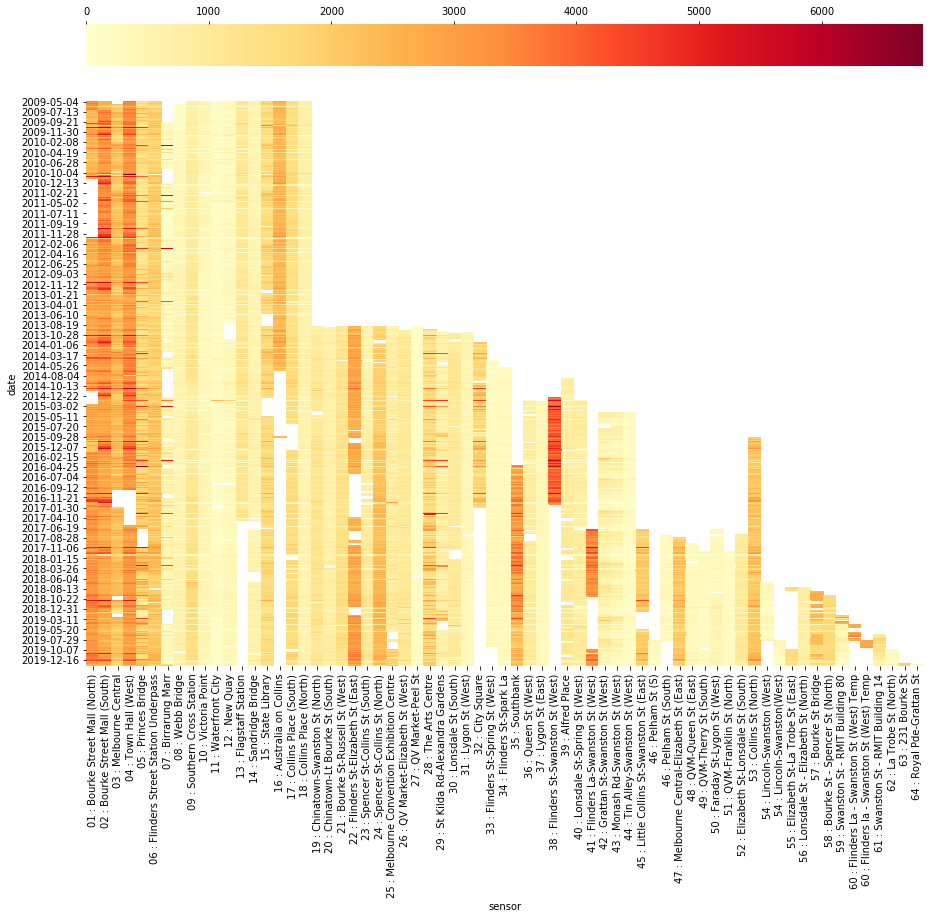

In [125]:
# Plot all available data, sampling at Monday noon only
fig, ax = plt.subplots(figsize=(15,13))
ax = sns.heatmap(table, cbar_kws = dict(use_gridspec=False,location="top"), cmap='YlOrRd')
plt.show()

# Shortlist sensor locations and period

In [22]:
# Group sensor locations based on availability of data

from google.colab import drive
drive.mount('/content/drive')

sensor_master = pd.read_excel('/content/drive/My Drive/Melb_project/CBD_grid.xlsx', sheet_name='master')
sensor_master = sensor_master.iloc[:,:8]
sensor_master.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,sensor_id,sensor_description,installation_date,CBD,Train_data,Test_data,x,y
0,1,Bourke Street Mall (North),2009-03-24,1,1,1,NaN,NaN
1,2,Bourke Street Mall (South),2009-03-30,1,1,1,NaN,NaN
2,3,Melbourne Central,2009-03-25,1,1,1,NaN,NaN
3,4,Town Hall (West),2009-03-23,1,1,1,NaN,NaN
4,5,Princes Bridge,2009-03-26,1,1,1,NaN,NaN


In [23]:
# List of sensor for training and test data
sensors = list(sensor_master[sensor_master['CBD']==1].sensor_id)
sensors_train_test = list(sensor_master[sensor_master['Train_data']==1].sensor_id)
sensors_test = list(sensor_master[(sensor_master['Train_data']==0)&sensor_master['Test_data']==1].sensor_id)
len(sensors)

42

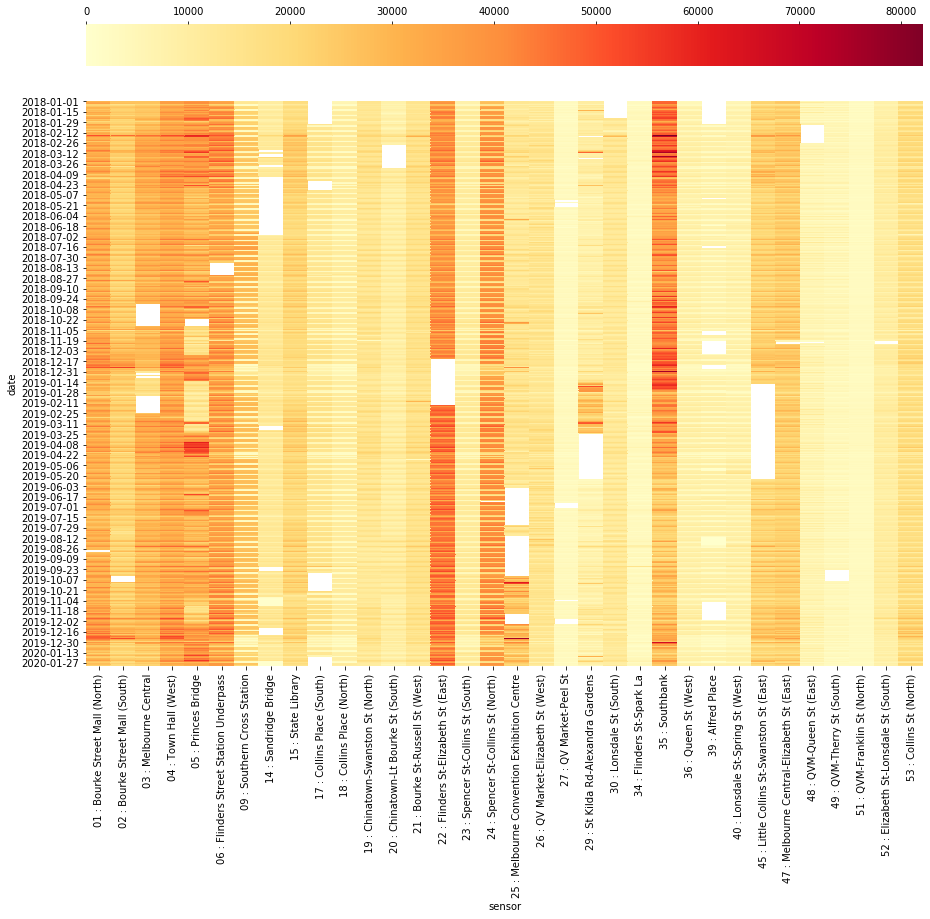

In [126]:
# Visualize training+test sensors for past 2 years
df2 = df[df['sensor_id'].isin(sensors_train_test)]
dfplot2 = df2[df2['year'] >= 2018][['date','sensor','hourly_counts']]

table2 = pd.pivot_table(dfplot2, values='hourly_counts', index='date',
                       columns='sensor', aggfunc=np.sum)

fig, ax = plt.subplots(figsize=(15,13))
ax = sns.heatmap(table2, cbar_kws = dict(use_gridspec=False,location="top"), cmap='YlOrRd')
plt.show()

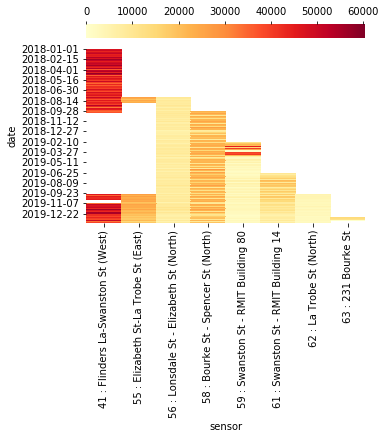

In [127]:
# Visualize test sensors only
df3 = df[df['sensor_id'].isin(sensors_test)]
table3 = pd.pivot_table(df3, values='hourly_counts', index='date',
                       columns='sensor', aggfunc=np.sum)

fig, ax = plt.subplots(figsize=(5,4))
ax = sns.heatmap(table3, cbar_kws = dict(use_gridspec=False,location="top"), cmap='YlOrRd')
plt.show()

In [0]:
# Download all data for shortlisted sensor for last 2 years

# pbar  = progressbar.ProgressBar()
# dfraw = pd.DataFrame(columns=dfraw0.columns)
# years = [2018, 2019, 2020]

# for year in years:
#     for sensor in sensors:
#         results = client.get("b2ak-trbp", sensor_id=sensor, year=year, limit=10000)
#         dfitem = pd.DataFrame.from_records(results)
#         dfraw = pd.concat([dfraw, dfitem])
# dfraw.to_csv('/content/drive/My Drive/Melb_project/sensors_data.csv')
# len(dfraw)

In [134]:
# Open from saved API
dfraw = pd.read_csv('/content/drive/My Drive/Melb_project/sensors_data.csv')
dfraw = dfraw.drop('Unnamed: 0', axis=1)

# First round of cleaning
df = dfraw.copy()
df['date_time'] = pd.to_datetime(df['date_time'])
df['date']    = df['date_time'].dt.date
df['day']     = df['date_time'].dt.dayofweek
df['week']    = df['date_time'].dt.weekofyear
df['month']   = df['date_time'].dt.month
df['year']    = df['year'].astype('int')
df['hourly_counts'] = df['hourly_counts'].astype('int')
df['sensor'] = (df['sensor_id'].map(lambda row: '0'+str(row)\
                                    if int(row)<10 else row)).astype('str')\
                                     + " : " + df['sensor_name']
df['sensor_id'] = df['sensor_id'].astype('int')
display(len(df))
display(df.head(3))

652723

,id,date_time,year,month,mdate,day,time,sensor_id,sensor_name,hourly_counts,date,week,sensor
0,2212970,2018-04-28 00:00:00,2018,4,28,5,0,1,Bourke Street Mall (North),314,2018-04-28,17,01 : Bourke Street Mall (North)
1,2213017,2018-04-28 01:00:00,2018,4,28,5,1,1,Bourke Street Mall (North),202,2018-04-28,17,01 : Bourke Street Mall (North)
2,2213064,2018-04-28 02:00:00,2018,4,28,5,2,1,Bourke Street Mall (North),129,2018-04-28,17,01 : Bourke Street Mall (North)


# Investigate variations by location

## 1. Variation by traffic volume

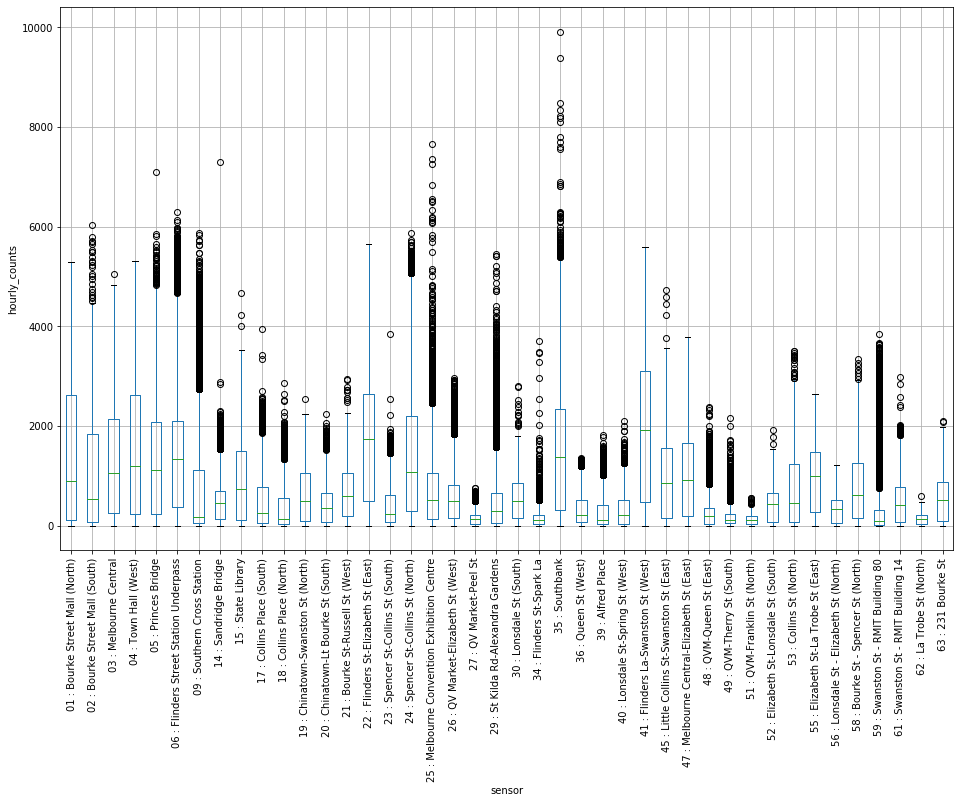

In [29]:
pivotvolume = pd.pivot_table(df, values='hourly_counts',
                             index='date_time', columns='sensor',
                             aggfunc=np.mean)
fig, ax = plt.subplots(figsize=(16,10))
pivotvolume.boxplot(ax=ax)
plt.xticks(rotation=90)
ax.set_xlabel('sensor')
ax.set_ylabel('hourly_counts')
plt.show()

### 2. Variation by hour

In [0]:
# Normalize data for each sensor
pivothour = pd.pivot_table(df, values='hourly_counts',
                           index='time', columns='sensor_id',
                           aggfunc=np.nanmean)
hourcols = pivothour.columns
pivothour = preprocessing.normalize(pivothour, norm='l1', axis=0)
dfhour = pd.DataFrame(pivothour, index=range(0,24), columns=hourcols)

# Normalize data for avg of all sensors
pivothour2 = pd.pivot_table(df, values='hourly_counts',
                            index='time', aggfunc=np.nanmean)
dfhour2 = preprocessing.normalize(pivothour2, norm='l1', axis=0)
dfhour2 = pd.DataFrame(dfhour2, index=range(0,24), columns=['all_sensors'])

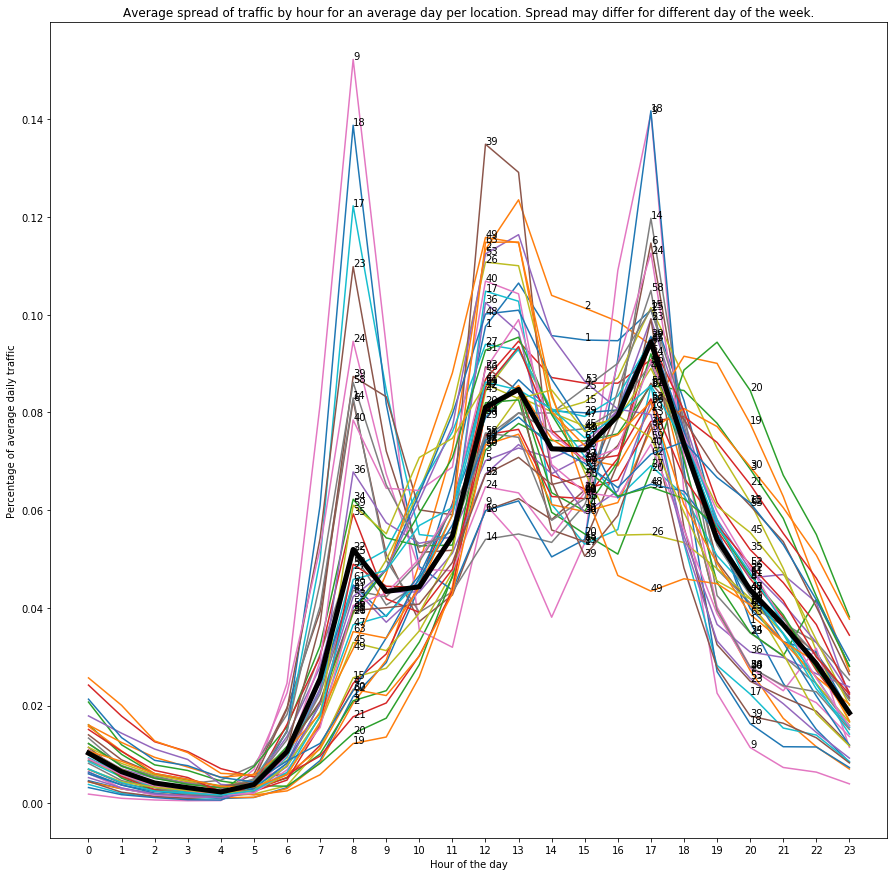

In [130]:
fig, ax = plt.subplots(figsize=(15,15))
ax.plot(dfhour)
ax.plot(dfhour2, linewidth=5, c='black')

for hour in [8,12,15,17,20]:
    labels = zip(dfhour[dfhour.index == hour].values[0], dfhour.columns)
    for y, label in labels:
        plt.text(hour, y, label, fontsize=10)

ax.set_title('Average spread of traffic by hour for an average day per location. Spread may differ for different day of the week.')

ax.set_ylabel('Percentage of average daily traffic')
ax.set_xlabel('Hour of the day')
ax.set_xticks(range(0,24))
plt.show()

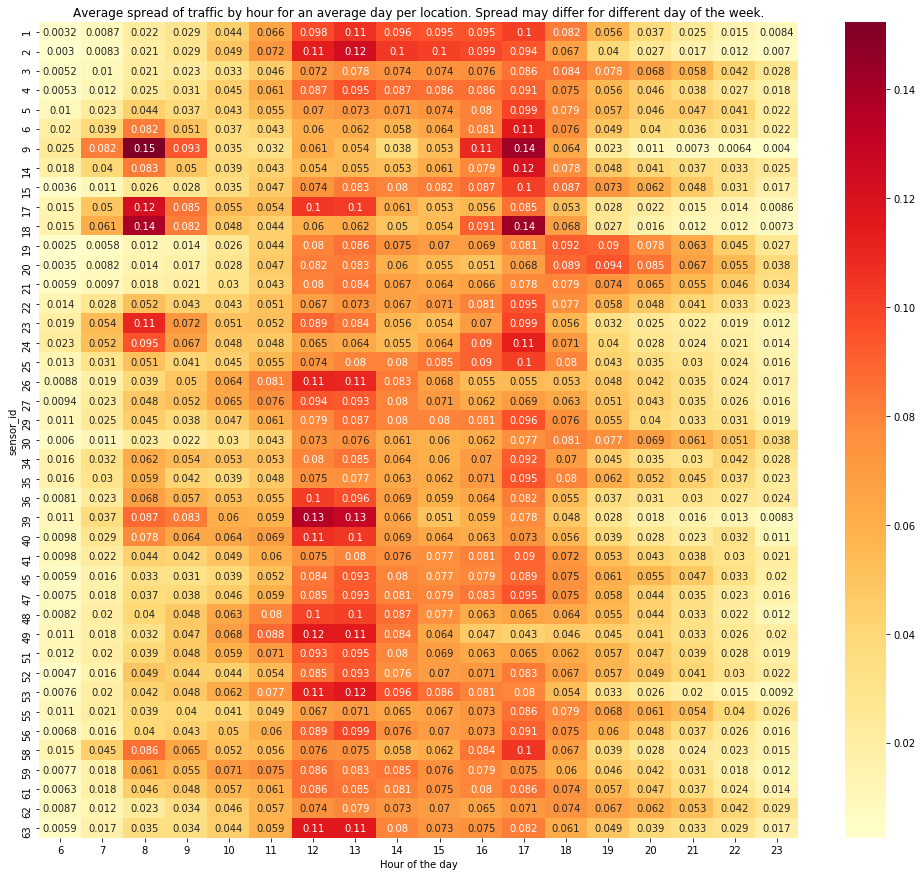

In [32]:
fig, ax = plt.subplots(figsize=(17,15))
sns.heatmap(dfhour[dfhour.index > 5].T, ax=ax, cmap='YlOrRd', annot=True)
ax.set_title('Average spread of traffic by hour for an average day per location. Spread may differ for different day of the week.')
ax.set_xlabel('Hour of the day')
plt.show()

1. How far back in time to use : prefer to limit to 2 years due to different intallation time per sensor, and 2 years should give monthly variation over 2 years

2. How to build a single general model for all sensors? Trade-off is half way: cluster similar sensor behaviours together and only generalize based on those clusters.


## 3. Variation by week day

In [0]:
# Normalize data for each sensor
pivotweek = pd.pivot_table(df, values='hourly_counts',
                           index='day', columns='sensor_id',
                           aggfunc=np.nanmean)
weekcols = pivotweek.columns
pivotweek = preprocessing.normalize(pivotweek, norm='l1', axis=0)
dfweek = pd.DataFrame(pivotweek, index=range(0,7), columns=weekcols)

# Normalize data for avg of all sensors
pivotweek2 = pd.pivot_table(df, values='hourly_counts',
                            index='day', aggfunc=np.nanmean)
dfweek2 = preprocessing.normalize(pivotweek2, norm='l1', axis=0)
dfweek2 = pd.DataFrame(dfweek2, index=range(0,7), columns=['all_sensors'])

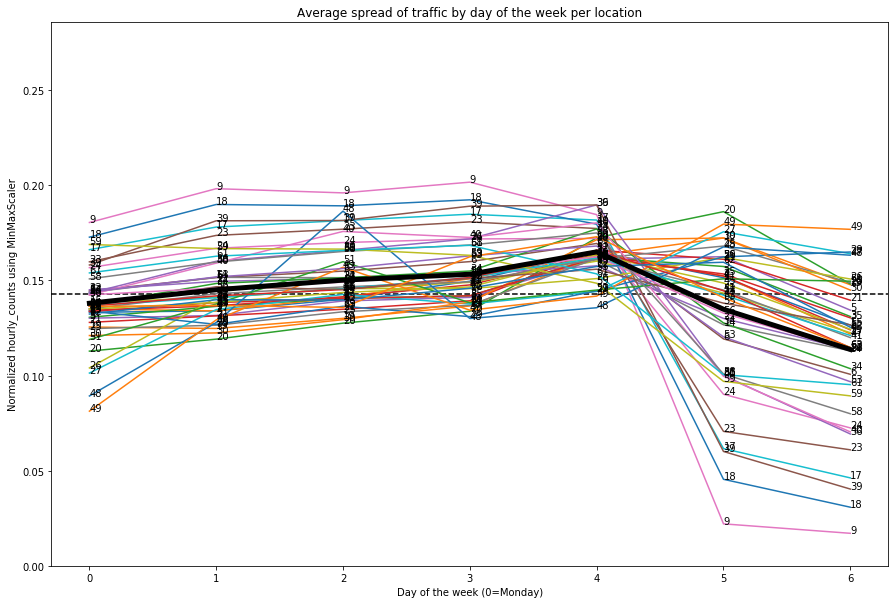

In [133]:
fig, ax = plt.subplots(figsize=(15,10))

ax.hlines(1/7,-0.3,6.3,linestyles='dashed') # if equal spread
ax.plot(dfweek) # actual spread
ax.plot(dfweek2, linewidth=5, c='black')

for day in range(0,7):
    labels = zip(dfweek[dfweek.index == day].values[0], dfweek.columns)
    for y, label in labels:
        plt.text(day, y, label, fontsize=10)

ax.set_title('Average spread of traffic by day of the week per location')
ax.set_ylabel('Normalized hourly_counts using MinMaxScaler')
ax.set_ylim(0,2/7)
ax.set_xlim(-0.3,6.3)
ax.set_xlabel('Day of the week (0=Monday)')
plt.show()

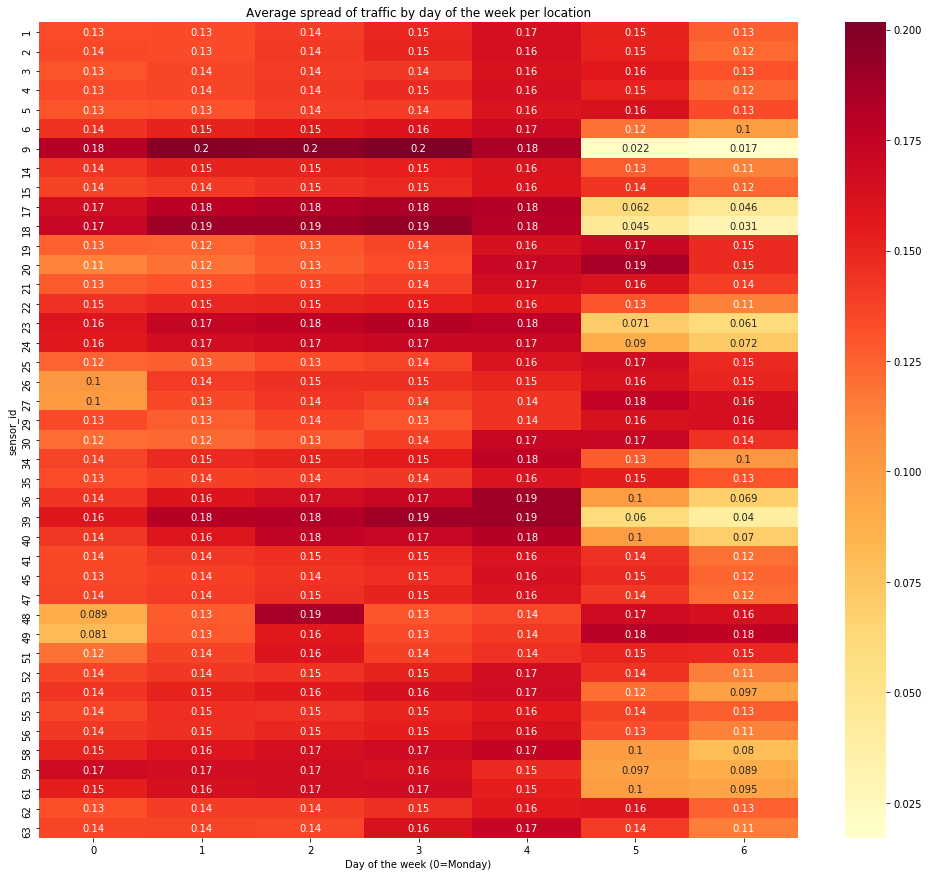

In [35]:
fig, ax = plt.subplots(figsize=(17,15))
sns.heatmap(dfweek.T, ax=ax, cmap='YlOrRd', annot=True)
ax.set_title('Average spread of traffic by day of the week per location')
ax.set_xlabel('Day of the week (0=Monday)')
plt.show()

# 4. Seasonal variation

In [0]:
# Normalize data by sensor
pivotseason = pd.pivot_table(df, values='hourly_counts',
                             index='week', columns='sensor_id',
                             aggfunc=np.nanmean)

nullcols = list((pivotseason.loc[:, pivotseason.isnull().any()]).columns)
dfseason = pivotseason = pivotseason.loc[:, pivotseason.columns.difference(nullcols)]
seasoncols = dfseason.columns
dfseason = preprocessing.normalize(dfseason, norm='l1', axis=0)
dfseason = pd.DataFrame(dfseason, index=range(0,52), columns=seasoncols)

# Normalize data for avg of all sensors
pivotseason2 = pd.pivot_table(df, values='hourly_counts',
                             index='week', aggfunc=np.nanmean)
dfseason2 = preprocessing.normalize(pivotseason2, norm='l1', axis=0)
dfseason2 = pd.DataFrame(dfseason2, index=range(0,52), columns=['all_sensors'])

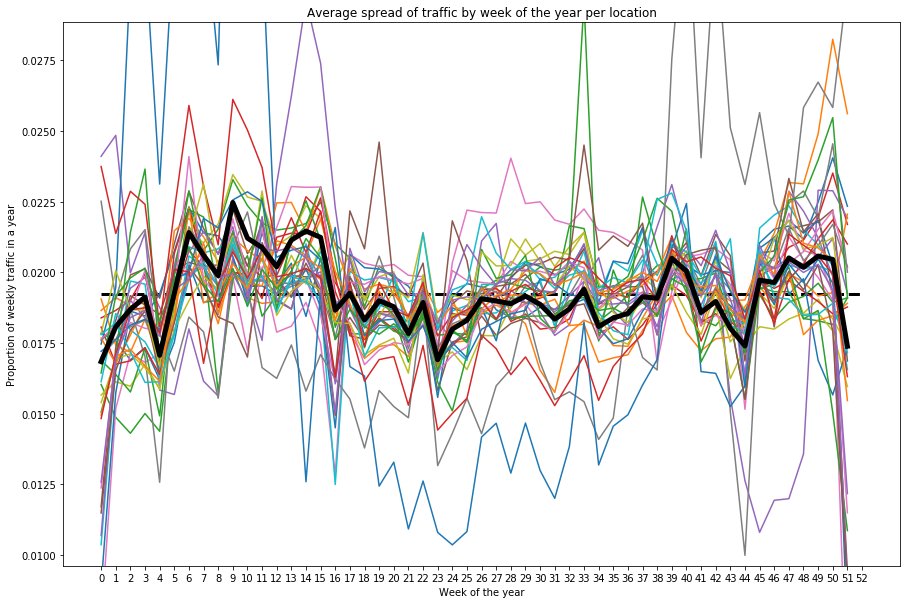

In [124]:
fig, ax = plt.subplots(figsize=(15,10))

ax.hlines(1/52,0,52,linestyles='dashed', linewidth=3) # if equal spread
ax.plot(dfseason)
ax.plot(dfseason2, linewidth=5, c='black')

ax.set_title('Average spread of traffic by week of the year per location')
ax.set_ylim(0.5/52,1.5/52)
ax.set_ylabel('Proportion of weekly traffic in a year')
ax.set_xlabel('Week of the year')
ax.set_xticks(range(0,53))
plt.show()

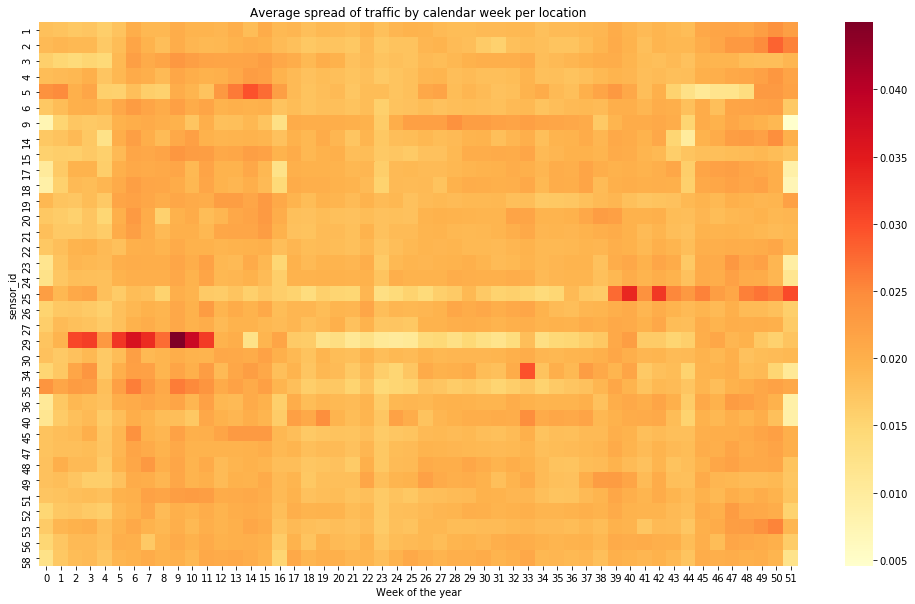

In [121]:
fig, ax = plt.subplots(figsize=(17,10))
sns.heatmap(dfseason.T, ax=ax, cmap='YlOrRd', annot=False)
ax.set_title('Average spread of traffic by calendar week per location')
ax.set_xlabel('Week of the year')
plt.show()

# To do list

EDA
1. Narrow down sites and period
2. Variation by high/low traffic sites
3. Variation by hour / week day / seasons

Assign sites to groups
1. Assign to clusters using EDA results (manual)
2. Use PCA to get better clusters (more data-driven)

Cleansing
1. Verify no missing timestamp
2. Restate outliers
3. Fill nulls based on general variation rule

Stinky model - ARMA/ARIMA
1. Test for stationarity
2. Differencing
3. PACF, ACF
4. Different model for different cluster

Enhanced models
1. Decision Tree
2. LSTM

Visualization
1. Static heatmap on city centre map
2. Variable heatmap animation
3. Variable hourly plot animation
4. Web app
